# Optimal Control Problems with `torchdyn`

We showcase the stabilization of an inverted pendulum via the ***Optimal Energy Shaping*** approach of [Massaroli et al., 2021](https://arxiv.org/abs/2101.05537)

## Define Controlled System Dynamics

We consider a controlled damped inverted pendulum with a torsional spring in the joint with state $(q_t, p_t)$ (joint angle and momentum), described by the Hamiltonian dynamics
$$
    \begin{aligned}
        \dot q_t &= \frac{1}{m}p_t \\
        \dot p_t &= \tau_{el} + \tau_{g} + \tau_{d} + u_t
    \end{aligned}
$$

with input torque $u_t$, elastic torque $\tau_{el} = - k (q - q_r)$, gravitational torque $\tau_g = mgl\sin q_t$ and damping (friction) $\tau_d = \frac{b}{m} p_t$.

The control policy (to be learned) is then defined as 

$$
    u_t = \gamma_\theta(q_t, p_t) = -\nabla_q V_\theta^*(q_t) - \frac{1}{m}K^*(q_t, p_t)p_t
$$

with $V^*_\theta:\mathbb R \rightarrow\mathbb R, ~K^*_\theta:\mathbb R^2 \rightarrow\mathbb R$ being two neural nets with parameters $\theta$


In [4]:
import torch
import torch.nn as nn
from torch.autograd import grad as grad

# physical parameters
m, k, l, qr, b, g = 1., 0.5, 1, 0, 0.01, 9.81

class ControlledSystem(nn.Module):
    # Elastic Pendulum Model
    def __init__(self, V, K):
        super().__init__()
        self.V, self.K, self.n = V, K, 1

    def forward(self, t, x):
        # Evaluates the closed-loop vector field
        with torch.set_grad_enabled(True):
            q, p = x[..., :self.n], x[..., self.n:]
            q = q.requires_grad_(True)
            # compute control action
            u = self._energy_shaping(q) + self._damping_injection(x)
            # compute dynamics
            dxdt = self._dynamics(q, p, u)
        return dxdt

    def _dynamics(self, q, p, u):
        # controlled elastic pendulum dynamics
        dqdt = p / m
        dpdt = -k * (q - qr) - m * g * l * torch.sin(q) - b * p / m + u
        return torch.cat([dqdt, dpdt], 1)

    def _energy_shaping(self, q):
        # energy shaping control action
        dVdx = grad(self.V(q).sum(), q, create_graph=True)[0]
        return -dVdx

    def _damping_injection(self, x):
        # damping injection control action
        return -self.K(x) * x[:, self.n:] / m

    def _autonomous_energy(self, x):
        # Hamiltonian (total energy) of the UNCONTROLLED system
        return (m * x[:, 1:] ** 2) / 2. + (k * (x[:, :1] - qr) ** 2) / 2 \
               + m * g * l * (1 - torch.cos(x[:, :1]))

    def _energy(self, x):
        # Hamiltonian (total energy) of the CONTROLLED system
        return (m * x[:, 1:] ** 2) / 2. + (k * (x[:, :1] - qr) ** 2) / 2 \
               + m * g * l * (1 - torch.cos(x[:, :1])) + self.V(x[:, :1])


class AugmentedDynamics(nn.Module):
    # "augmented" vector field to take into account integral loss functions
    def __init__(self, f, int_loss):
        super().__init__()
        self.f = f
        self.int_loss = int_loss
        self.nfe = 0.

    def forward(self, t, x):
        self.nfe += 1
        x = x[:,:2]
        dxdt = self.f(t, x)
        dldt = self.int_loss(t, x)
        return torch.cat([dxdt, dldt], 1)

### Define `pytorch_lightning` learner

In [60]:
import pytorch_lightning as pl
import torch.utils.data as data

class EnergyShapingLearner(pl.LightningModule):
    def __init__(self, model: nn.Module, prior_dist, target_dist, t_span, sensitivity='autograd'):
        super().__init__()
        self.model = model
        self.prior, self.target = prior_dist, target_dist
        self.t_span = t_span
        self.batch_size = 2048
        self.lr = 5e-3
        self.weight = torch.Tensor([1., 1.]).reshape(1, 2)

    def forward(self, x):
        return self.model.odeint(x, self.t_span)
    
    def training_step(self, batch, batch_idx):
        # sample a batch of initial conditions
        x0 = self.prior.sample((self.batch_size,))

        # Integrate the model
        x0 = torch.cat([x0, torch.zeros(self.batch_size, 1).to(x0)], 1)
        _, xTl = self(x0)
        xT, l = xTl[-1, :, :2], xTl[-1, :, -1:]

        # Compute loss
        terminal_loss = weighted_log_likelihood_loss(xT, self.target, self.weight.to(xT))
        integral_loss = torch.mean(l)
        loss = terminal_loss + 0.01 * integral_loss
        return {'loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
        return [optimizer], [scheduler]

    def train_dataloader(self):
        dummy_trainloader = data.DataLoader(
            data.TensorDataset(torch.Tensor(1, 1), torch.Tensor(1, 1)),
            batch_size=1)
        return dummy_trainloader

#### Define Initial and Target distributions

In [61]:
import torch
from torch.distributions import Uniform, Normal

def prior_dist(q_min, q_max, p_min, p_max, device='cpu'):
    # uniform "prior" distribution of initial conditions x(0)=[q(0),p(0)]
    lb = torch.Tensor([q_min, p_min]).to(device)
    ub = torch.Tensor([q_max, p_max]).to(device)
    return Uniform(lb, ub)

def target_dist(mu, sigma, device='cpu'):
    # normal target distribution of terminal states x(T)
    mu, sigma = torch.Tensor(mu).reshape(1, 2).to(device), torch.Tensor(sigma).reshape(1, 2).to(device)
    return Normal(mu, torch.sqrt(sigma))

#### Define Weighted NNL Loss Function and (integral) Control Effort Loss

We train the controller to solve the following nonlinear problem

$$
    \begin{aligned}
        \min_\theta \mathbb E_{x_0}\left[\log p(x_T) + \int_0^T |u_t|\right]dt \\
        a
    \end{aligned}
$$

In [62]:
def weighted_log_likelihood_loss(x, target, weight):
    # weighted negative log likelihood loss
    log_prob = target.log_prob(x)
    weighted_log_p = weight * log_prob
    return -torch.mean(weighted_log_p.sum(1))

class ControlEffort(nn.Module):
    # control effort integral cost
    def __init__(self, f):
        super().__init__()
        self.f = f
    def forward(self, t, x):
        with torch.set_grad_enabled(True):
            q = x[:,:1].requires_grad_(True)
            u = self.f._energy_shaping(q) + self.f._damping_injection(x)
        return torch.abs(u)

## Train The Control Policy

In [63]:
from numpy import pi as pi
from sys import path
path.append("../..")

prior = prior_dist(-2*pi, 2*pi, -2*pi, 2*pi) # Uniform "prior" distribution of initial conditions x(0) 
target = target_dist([0, 0], [.001, .001]) # Normal target distribution for x(T)

# define optimal energy shaping policy networks
hdim = 64
V = nn.Sequential(
          nn.Linear(1, hdim),
          nn.Softplus(), 
          nn.Linear(hdim, hdim),
          nn.Tanh(), 
          nn.Linear(hdim, 1))
K = nn.Sequential(
          nn.Linear(2, hdim),
          nn.Softplus(),
          nn.Linear(hdim, 1),
          nn.Softplus())

# init to zero par.s of the final layer
for p in V[-1].parameters(): torch.nn.init.zeros_(p)
for p in K[-2].parameters(): torch.nn.init.zeros_(p)

# define controlled system dynamics
f = ControlledSystem(V, K)
aug_f = AugmentedDynamics(f, ControlEffort(f))

# define time horizon
t_span = torch.linspace(0, 3, 30)

In [64]:
from torchdyn.models import ODEProblem

solver = 'tsit5'
sensitivity = 'interpolated_adjoint'
interpolator = None

prob = ODEProblem(aug_f, sensitivity=sensitivity, interpolator=interpolator, solver=solver, atol=1e-4, rtol=1e-4, atol_adjoint=1e-4, rtol_adjoint=1e-4)

In [65]:
# train (it can be very slow on CPU)
learn = EnergyShapingLearner(prob, prior, target, t_span)
trainer = pl.Trainer(max_epochs=650)
trainer.fit(learn)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | ODEProblem | 4.6 K 
-------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


### Plot Results

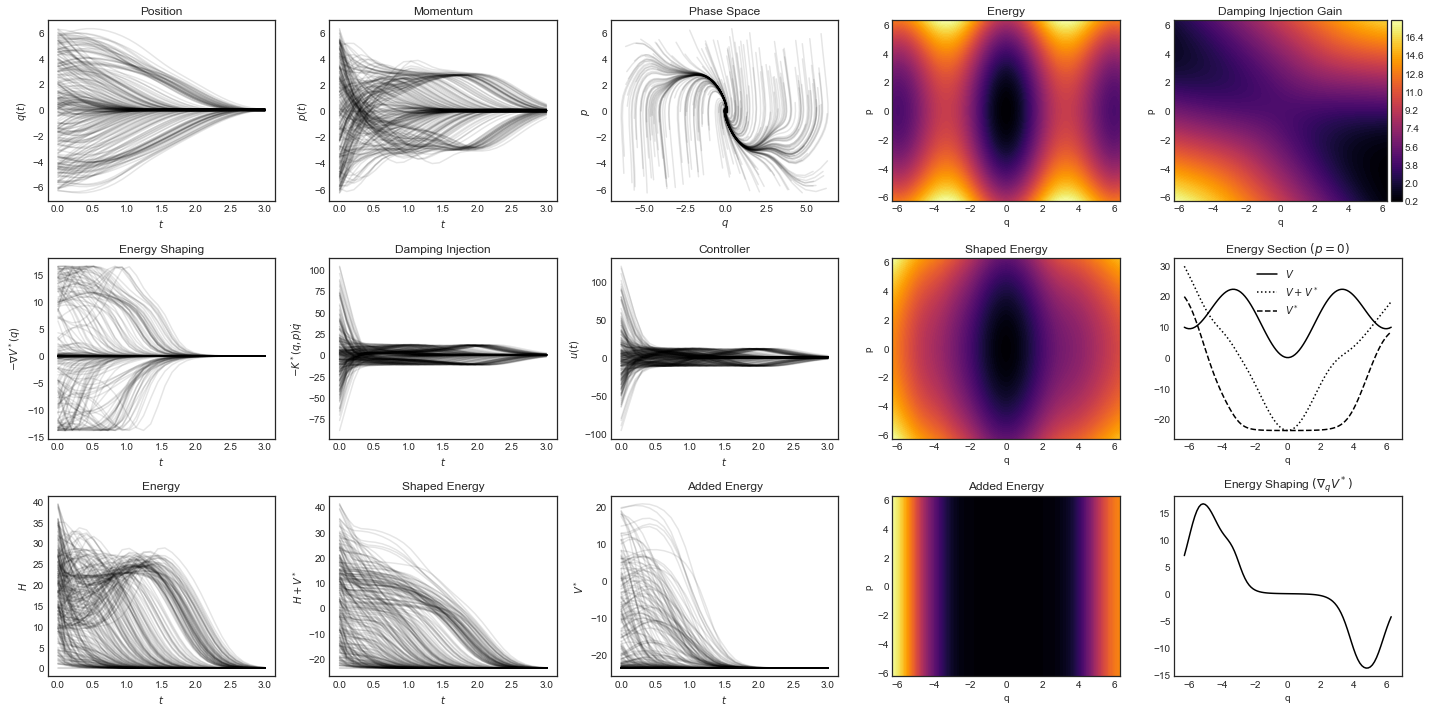

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torchdiffeq import odeint

n_ic = 256
x0 = prior.sample(torch.Size([n_ic])).cpu()
x0 = torch.cat([x0, torch.zeros(n_ic, 1)], 1)
model = aug_f.cpu()
#
traj = odeint(model, x0, t_span, method='midpoint').detach()
traj = traj[..., :-1]
u_es = torch.cat([model.f._energy_shaping(q.requires_grad_()) for q in traj[:,:,:1]], 1).detach()
u_di = torch.cat([model.f._damping_injection(x) for x in traj], 1).detach()
u = (u_es + u_di)
H = torch.cat([model.f._autonomous_energy(x) for x in traj], 1).detach()
Hd = torch.cat([model.f._energy(x) for x in traj], 1).detach()
Ha = Hd - H
# plots on grid
n_grid = 100
q_grid, p_grid = torch.linspace(-2*pi, 2*pi, n_grid), torch.linspace(-2*pi, 2*pi, n_grid)
Q, P = torch.meshgrid(q_grid, p_grid) ; z = torch.cat([Q.reshape(-1, 1), P.reshape(-1, 1)], 1)
H_grid = model.f._autonomous_energy(z).reshape(n_grid, n_grid).detach()
Hd_grid = model.f._energy(z).reshape(n_grid, n_grid).detach()
Ha_grid = Hd_grid - H_grid
Kd_grid = -model.f._damping_injection(z).reshape(n_grid, n_grid).detach()/P   
#
V_sec = model.f._autonomous_energy(torch.cat([q_grid[:,None], torch.zeros(n_grid,1)],1)).detach()
Vd_sec = model.f._energy(torch.cat([q_grid[:,None], torch.zeros(n_grid,1)],1)).detach()
Va_sec = Vd_sec - V_sec
u_es_sec = model.f._energy_shaping(q_grid[:, None].requires_grad_()).detach()
#
############

# plot
plt.style.use('seaborn-white')
fig, ax = plt.subplots(3, 5, figsize=(20,10))
##
ax[0,0].set_xlabel(r"$t$") ; ax[0,1].set_xlabel(r"$t$") ; ax[0,2].set_xlabel(r"$q$")
ax[0,0].set_ylabel(r"$q(t)$") ; ax[0,1].set_ylabel(r"$p(t)$") ; ax[0,2].set_ylabel(r"$p$")
ax[1,0].set_xlabel(r"$t$") ; ax[1,1].set_xlabel(r"$t$") ; ax[1,2].set_xlabel(r"$t$")
ax[1,0].set_ylabel(r"$-\nabla V^*(q)$") ; ax[1,1].set_ylabel(r"$-K^*(q,p)\dot q$") ; ax[1,2].set_ylabel(r"$u(t)$")
ax[2,0].set_xlabel(r"$t$") ; ax[2,1].set_xlabel(r"$t$") ; ax[2,2].set_xlabel(r"$t$")
ax[2,0].set_ylabel(r"$H$") ; ax[2,1].set_ylabel(r"$H + V^*$") ; ax[2,2].set_ylabel(r"$V^*$")
ax[0,0].set_title("Position") ; ax[0,1].set_title("Momentum") ; ax[0,2].set_title("Phase Space") 
ax[1,0].set_title("Energy Shaping") ; ax[1,1].set_title("Damping Injection") ; ax[1,2].set_title("Controller") 
ax[2,0].set_title("Energy") ; ax[2,1].set_title("Shaped Energy") ; ax[2,2].set_title("Added Energy") 
for i in range(n_ic):
    ax[0,0].plot(t_span, traj[:,i,0], 'k', alpha=.1)
    ax[0,1].plot(t_span, traj[:,i,1], 'k', alpha=.1)
    ax[0,2].plot(traj[:,i,0], traj[:,i,1], 'k', alpha=.1)
    ax[1,0].plot(t_span, u_es[i,:], 'k', alpha=.1)
    ax[1,1].plot(t_span, u_di[i,:], 'k', alpha=.1)
    ax[1,2].plot(t_span, u[i,:], 'k', alpha=.1)
    ax[2,0].plot(t_span, H[i,:], 'k', alpha=.1)
    ax[2,1].plot(t_span, Hd[i,:], 'k', alpha=.1)
    ax[2,2].plot(t_span, Ha[i,:], 'k', alpha=.1)
##
ax[0,3].set_xlabel("q") ; ax[1,3].set_xlabel("q") ; ax[2,3].set_xlabel("q") ; ax[0,4].set_xlabel("q")
ax[0,3].set_ylabel("p") ; ax[1,3].set_ylabel("p") ; ax[2,3].set_ylabel("p") ; ax[0,4].set_ylabel("p")
ax[0,3].set_title("Energy") ; ax[1,3].set_title("Shaped Energy") ; ax[2,3].set_title("Added Energy") ; ax[0,4].set_title("Damping Injection Gain") 
ax[0,3].contourf(Q, P, H_grid, 100, cmap='inferno')
ax[1,3].contourf(Q, P, Hd_grid, 100, cmap='inferno')
ax[2,3].contourf(Q, P, Ha_grid, 100, cmap='inferno')
plot = ax[0,4].contourf(Q, P, Kd_grid, 100, cmap='inferno') ; divider = make_axes_locatable(ax[0,4])
cax = divider.append_axes("right", size="5%", pad=0.05) ; plt.colorbar(plot, cax=cax)
##
ax[1,4].set_title(r"Energy Section $(p=0)$") ; ax[1,4].set_xlabel("q")
ax[1,4].plot(q_grid, V_sec, 'k') ; ax[1,4].plot(q_grid, Vd_sec, ':k') ; ax[1,4].plot(q_grid, Va_sec, '--k')
ax[1,4].legend(['$V$', r"$V+V^*$", "$V^*$"])
##
ax[2,4].set_title(r"Energy Shaping $(\nabla_q V^*)$") ; ax[2,4].set_xlabel("q")
ax[2,4].plot(q_grid, u_es_sec, 'k')
fig.tight_layout()